In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')

In [2]:
temp = pd.read_csv(r'C:\Users\admin\DSP\ABC_Level_One_Tick_Data.csv')
# Assumption :  Cost = Volume * Avg_Big_Ask_Spread
# Absolute value is considered

In [3]:
data = temp[['Open','High','Low','Close','VWAP','TWAP','NumberOfTrades','Volume','Avg_Bid_Ask_Spread','Cost']]

# Assumption : These are the variables required to build the model
#    Cost = Dependent variable
#    Other variables are independent variables

In [4]:
data.head()

,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Avg_Bid_Ask_Spread,Cost
0,53.545455,54.254545,53.518182,54.209091,53.951161,53.989410,3365,254615.54550,-0.014760,3758.125452
1,54.209091,54.363636,54.100000,54.290909,54.224500,54.225053,1368,77817.18182,0.013481,1049.046347
2,54.281818,54.318182,54.218182,54.245455,54.265969,54.266231,909,58191.72727,0.011557,672.537678
3,54.245455,54.272727,54.118182,54.136364,54.183729,54.182949,501,34762.09091,0.011537,401.059733
4,54.181818,54.204591,54.100000,54.177318,54.158934,54.156843,474,34644.18182,-0.014078,487.727097


In [5]:
#Checking Missing values
sum(data.isnull().sum())

0

In [6]:
#Checking column  and their data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 10 columns):
Open                  1023 non-null float64
High                  1023 non-null float64
Low                   1023 non-null float64
Close                 1023 non-null float64
VWAP                  1023 non-null float64
TWAP                  1023 non-null float64
NumberOfTrades        1023 non-null int64
Volume                1023 non-null float64
Avg_Bid_Ask_Spread    1023 non-null float64
Cost                  1023 non-null float64
dtypes: float64(9), int64(1)
memory usage: 80.0 KB


In [7]:
#Checking Data Dimension
data.shape

(1023, 10)

In [8]:
#Outlier treatment
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

#Implementing outlier function 
data_new=data.apply(outlier_capping)

In [9]:
data_new.head()

,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Avg_Bid_Ask_Spread,Cost
0,53.545455,54.254545,53.518182,54.172727,53.951161,53.989410,3365.0,254615.54550,-0.014760,3758.125452
1,54.179818,54.254545,54.100000,54.172727,54.168020,54.162035,1368.0,77817.18182,0.013481,1049.046347
2,54.179818,54.254545,54.100000,54.172727,54.168020,54.162035,909.0,58191.72727,0.011557,672.537678
3,54.179818,54.254545,54.100000,54.136364,54.168020,54.162035,501.0,34762.09091,0.011537,401.059733
4,54.179818,54.204591,54.100000,54.172727,54.158934,54.156843,474.0,34644.18182,-0.014078,487.727097


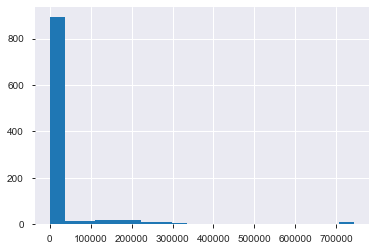

In [10]:
#Checking the Distribution of Cost
# Target variable following Exponential distribution.
data_new.Cost.hist(bins=20)
plt.show()

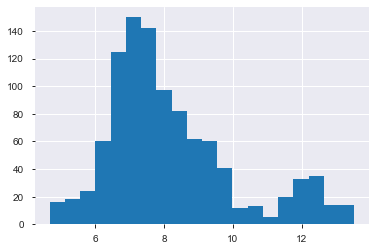

In [11]:
#Applying transformation for target variable to make it into Near normal
import numpy as np
np.log(data_new.Cost).hist(bins=20)
plt.show()

In [12]:
data_new['ln_cost'] =  np.log(data_new.Cost)

In [13]:
data_new.head()

,Open,High,Low,Close,VWAP,TWAP,NumberOfTrades,Volume,Avg_Bid_Ask_Spread,Cost,ln_cost
0,53.545455,54.254545,53.518182,54.172727,53.951161,53.989410,3365.0,254615.54550,-0.014760,3758.125452,8.231676
1,54.179818,54.254545,54.100000,54.172727,54.168020,54.162035,1368.0,77817.18182,0.013481,1049.046347,6.955637
2,54.179818,54.254545,54.100000,54.172727,54.168020,54.162035,909.0,58191.72727,0.011557,672.537678,6.511058
3,54.179818,54.254545,54.100000,54.136364,54.168020,54.162035,501.0,34762.09091,0.011537,401.059733,5.994110
4,54.179818,54.204591,54.100000,54.172727,54.158934,54.156843,474.0,34644.18182,-0.014078,487.727097,6.189756


## Variable Reduction

In [14]:
# Recursive Feature Elimination

In [15]:
features = data_new[data_new.columns.difference( ['Cost', 'ln_cost'] )]
target = data_new['ln_cost']

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import itertools

lm = LinearRegression()

# create the RFE model and select 10 attributes
rfe = RFE(lm, n_features_to_select=20)
rfe = rfe.fit(features, target)

In [17]:
rfe.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [18]:
# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(features.columns, rfe.get_support())]

In [19]:
feature_map

[('Avg_Bid_Ask_Spread', True),
 ('Close', True),
 ('High', True),
 ('Low', True),
 ('NumberOfTrades', True),
 ('Open', True),
 ('TWAP', True),
 ('VWAP', True),
 ('Volume', True)]

### F-Regression

In [20]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(features, target )

In [21]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]

In [22]:
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

In [23]:
f_reg_results.sort_values(by=['P_Value'])

,Variable,F_Value,P_Value
0,Avg_Bid_Ask_Spread,351.313317,0.000
4,NumberOfTrades,151.685000,0.000
8,Volume,1830.499001,0.000
3,Low,3.287507,0.070
5,Open,2.585942,0.108
6,TWAP,2.508671,0.114
7,VWAP,2.293329,0.130
1,Close,2.155869,0.142
2,High,1.524333,0.217


In [24]:
f_reg_results.P_Value = pd.to_numeric(f_reg_results.P_Value)

In [25]:
f_reg_results_new=f_reg_results[f_reg_results.P_Value<=0.2]

In [26]:
f_reg_results_new

,Variable,F_Value,P_Value
0,Avg_Bid_Ask_Spread,351.313317,0.000
1,Close,2.155869,0.142
3,Low,3.287507,0.070
4,NumberOfTrades,151.685000,0.000
5,Open,2.585942,0.108
6,TWAP,2.508671,0.114
7,VWAP,2.293329,0.130
8,Volume,1830.499001,0.000


#### Train and Test data

In [27]:
#Splitting data into training and testing data sets
train_reg, test_reg = train_test_split(data_new, test_size = 0.3)

In [28]:
model_reg = sm.ols('ln_cost~Open+High+Low+Close+VWAP+TWAP+NumberOfTrades+Volume+Avg_Bid_Ask_Spread',data = train_reg).fit()

In [29]:
print(model_reg.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.678    
Dependent Variable: ln_cost          AIC:                2121.8021
Date:               2021-03-19 17:15 BIC:                2167.5389
No. Observations:   716              Log-Likelihood:     -1050.9  
Df Model:           9                F-statistic:        168.2    
Df Residuals:       706              Prob (F-statistic): 4.52e-169
R-squared:          0.682            Scale:              1.1181   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           6.4719   0.2712 23.8665 0.0000  5.9395  7.0043
Open               -0.2858   0.2530 -1.1298 0.2590 -0.7825  0.2109
High               -0.1665   0.2114 -0.7876 0.4312 -0.5815  0.2485
Low                -0.2268   0.1713 -1.3243 0.1858 -0.5630  0.1094
Close        

In [30]:
#Transforming log values into actual values in both training and testing data sets
train_reg['pred'] =np.exp(model_reg.predict(train_reg))
test_reg['pred'] =np.exp(model_reg.predict(test_reg))
train_reg['ln_cost'] = np.exp(train_reg.ln_cost)
test_reg['ln_cost'] = np.exp(test_reg.ln_cost)

In [31]:
#Checking Metrics for both training and testing data sets

print("MAPE for Training and testing data sets:")
MAPE_train = np.mean(np.abs(train_reg.ln_cost - train_reg.pred)/train_reg.ln_cost)
print(MAPE_train)
MAPE_train = np.mean(np.abs(test_reg.ln_cost - test_reg.pred)/test_reg.ln_cost)
print(MAPE_train)
print("\nMSE for Training and testing data sets:")
#MSE for training and testing data sets                           
print(metrics.mean_squared_error(train_reg.ln_cost,train_reg.pred)) 
print(metrics.mean_squared_error(test_reg.ln_cost,test_reg.pred))
print("\nRMSE for Training and testing data sets:")
#RMSE for training and testing data sets                           
print(np.sqrt(metrics.mean_squared_error(train_reg.ln_cost,train_reg.pred)))
print(np.sqrt(metrics.mean_squared_error(test_reg.ln_cost,test_reg.pred)))

MAPE for Training and testing data sets:
1.1497257195229402
2.0443028111280714

MSE for Training and testing data sets:
529658282361.2294
6039563653625.292

RMSE for Training and testing data sets:
727776.2584484529
2457552.3704745932


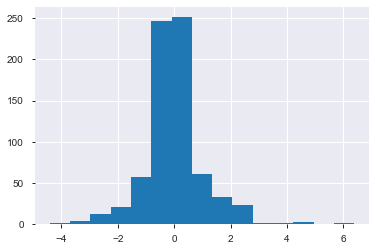

In [32]:
#Checking Errors distribution
model_reg.resid.hist(bins=15)
model_reg.resid.to_csv("Residual.csv")
# Residuals following Normal distribution. This is one of the Assumption in Linear Regression.

### K - Nearest Neighbours

In [33]:
#Importing required modules
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [34]:
X = data_new[data_new.columns.difference(['ln_cost'])]
target = data_new[['ln_cost']]
features = X

In [35]:
#Splitting the data for sklearn methods
train_y, test_y, train_x, test_x = train_test_split(target,features, test_size=0.3, random_state=123)

In [36]:
#Standardising the data because KNN is distance based algorithm 
scaler = StandardScaler()
train_X = scaler.fit_transform(train_x)
test_X = scaler.fit_transform(test_x)

In [37]:
#Model Building using different tuning parameters
tuned_parameters = [{'n_neighbors': [3,5, 7, 9,11],
                    'leaf_size':[20,30,40,50,60]}]

knn_reg = GridSearchCV(KNeighborsRegressor(),
                   tuned_parameters,
                   cv=3)

data_knn = knn_reg.fit(train_X,train_y)

In [38]:
#Predicting values for both training and testing data sets
knn_train_pred=data_knn.predict(train_X)
knn_test_pred=data_knn.predict(test_X)

In [39]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - knn_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- knn_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,knn_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,knn_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
ln_cost    0.029971
dtype: float64
ln_cost    0.045948
dtype: float64

RMSE values for training and testing data :
0.3903742332816778
0.7083613573170393


## ANN(Artificial Neural Network)

In [40]:
#Importing required Module
from sklearn.neural_network import MLPRegressor

In [41]:
pargrid_ann = {'activation': ['relu','tanh','logistic','identity'],
               'alpha':[0.0001,0.001,0.01,1,10,100,1000]}

ann_reg = GridSearchCV(MLPRegressor(),pargrid_ann,cv=3)

data_ann = ann_reg.fit(train_X,train_y)

In [42]:
#Predicting values for both training and testing data sets
ann_train_pred=data_ann.predict(train_X)
ann_test_pred=data_ann.predict(test_X)

In [43]:
#Metrics for both training and testing data 


#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,ann_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,ann_test_pred))
print(RMSE_test)


RMSE values for training and testing data :
0.558836853645257
0.6364783346014814


## SVM(Support Vector Machine) 

In [44]:
#Importing required modules
from sklearn.svm import SVR
from sklearn.svm import LinearSVR 

In [45]:
#Model building using Linear svm 
tuned_parameters = [{'C': [1,0.1,0.001,10,100],
                    'gamma':[0.0001, 0.001, 0.01, 0.1],
                    'kernel':['linear','rbf','poly']}]

svr_reg = GridSearchCV(SVR(),
                   tuned_parameters,
                   cv=3)

data_svr = svr_reg.fit(train_X,train_y)

In [46]:
#Predicting values for both training and testing data sets
L_svr_train_pred=data_svr.predict(train_x)
L_svr_test_pred=data_svr.predict(test_x)

In [47]:
#Metrics for both training and testing data 


#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,L_svr_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,L_svr_test_pred))
print(RMSE_test)


RMSE values for training and testing data :
3.522114414173996
3.4950359661620527


-------------------------------------- End -------------------------------------------------------------------------